In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucb import UCB
from exp3 import Exp3
from exp4 import Exp4

sns.set_theme()

## Preprocessing Movielens data

In [2]:
print('reading movielens 1m data')
ratings = pd.read_csv('../../data/ml-1m/ratings.dat', sep='::', names=['UserID','MovieID','Rating','Timestamp'], encoding = "ISO-8859-1")
movies = pd.read_csv('../../data/ml-1m/movies.dat', sep='::', names=['MovieID','Title','Genres'], encoding = "ISO-8859-1")
users = pd.read_csv('../../data/ml-1m/users.dat', sep='::', names=['UserID','Gender','Age','Occupation', 'Zip'], encoding = "ISO-8859-1")
#ratings = pd.read_csv('../data/ml-1m/ratings.dat', sep=':', usecols=range(0,5,2), names=['UserID','MovieID','Rating'], encoding = "ISO-8859-1")
#movies = pd.read_csv('../data/ml-1m/movies.dat', sep=':', usecols=range(0,5,2), names=['MovieID','Title','Genres'], encoding = "ISO-8859-1")
#users = pd.read_csv('../data/ml-1m/users.dat', sep=':', usecols=range(0,7,2), names=['UserID','Gender','Age','Occupation'], encoding = "ISO-8859-1")

movies = movies.join(movies['Genres'].str.get_dummies().astype(bool))
movies.drop('Genres', inplace=True, axis=1)
ratings['Liked'] = ratings['Rating'].apply(lambda x: 1 if x == 5 else 0)

reading movielens 1m data


C:\Users\fromm\AppData\Local\Temp\ipykernel_22200\2005891700.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('../data/ml-1m/ratings.dat', sep='::', names=['UserID','MovieID','Rating','Timestamp'], encoding = "ISO-8859-1")
C:\Users\fromm\AppData\Local\Temp\ipykernel_22200\2005891700.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv('../data/ml-1m/movies.dat', sep='::', names=['MovieID','Title','Genres'], encoding = "ISO-8859-1")
C:\Users\fromm\AppData\Local\Temp\ipykernel_22200\2005891700.py:8: ParserWarning: Falling back to the 'python' engine because the

In [3]:
top10ids = ratings['MovieID'].value_counts().head(10)
most_rated = movies.loc[movies['MovieID'].isin(top10ids.index)]
print(top10ids.index)

100
Int64Index([2858,  260, 1196, 1210,  480, 2028,  589, 2571, 1270,  593, 1580,
            1198,  608, 2762,  110, 2396, 1197,  527, 1617, 1265, 1097, 2628,
            2997,  318,  858,  356, 2716,  296, 1240,    1, 1214, 2916,  457,
            3578, 1200,  541, 2987, 1259,   50,   34, 2791,  780, 3175, 1193,
             919,  924, 1127, 2355, 1387, 1221,  912, 1036, 1213, 1610,  377,
            1291, 2000, 1136, 3114, 1307, 1704, 1721, 1968,  648, 2599, 3793,
              32, 2174, 2797, 2291, 2918,  590, 3471, 2959, 1374, 2683, 1394,
             592, 1784, 1573, 1304, 3418,  223,  380, 2706, 1225, 1584, 1527,
            3481, 1923, 2699,  750,   39,   21, 1393, 2804,  588, 2406, 1220,
             733],
           dtype='int64')


In [4]:
ratings_top10 = ratings.loc[ratings['MovieID'].isin(top10ids.index)]
ratings_top10

,UserID,MovieID,Rating,Timestamp,Liked
0,1,1193,5,978300760,1
4,1,2355,5,978824291,1
5,1,1197,3,978302268,0
7,1,2804,5,978300719,1
9,1,919,4,978301368,0
...,...,...,...,...,...
1000184,6040,2791,4,956715569,0
1000186,6040,527,5,956704219,1
1000193,6040,541,4,956715288,0
1000200,6040,2028,5,956704519,1


In [5]:
users_top10 = users.loc[users['UserID'].isin(ratings_top10['UserID'])]
users_top10

,UserID,Gender,Age,Occupation,Zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [6]:
data = pd.merge(ratings_top10, users_top10, on='UserID').sample(frac=1,random_state=5).reset_index(drop=True)
data

,UserID,MovieID,Rating,Timestamp,Liked,Gender,Age,Occupation,Zip
0,3344,1573,3,967776363,0,M,35,0,08902
1,498,2716,4,976212456,0,M,35,17,55113
2,3964,858,4,965669402,0,M,56,16,66502
3,1680,588,4,974713412,0,M,25,20,95380
4,3437,1,5,967326085,1,F,25,0,37203
...,...,...,...,...,...,...,...,...,...
183137,4014,3175,4,965536784,0,M,25,0,48316-5601
183138,4089,1200,4,965503776,0,M,25,7,79416
183139,699,590,4,975559515,0,M,18,0,73505
183140,646,2858,2,975715946,0,M,35,7,08505


Bandit implementations require knowledge of time horizon, number of arms (movies) k, and the reward function for taking action A at time step t. When evaluating offline using replay, the time horizon can vary. This can influence the performance of the algorithms as the value updates depend on the time horizon. THe time horizon can vary between 0 and the length of dataset, however the expected time horizon is length of dataset / k.

In [1]:
horizon = len(data.index)*10
k = len(top10ids.index)
M = 10

def reward(t,A):
    t = t % len(data.index)
    if data['MovieID'].iloc[t] == top10ids.index[A]:
        return data['Liked'].iloc[t]
    return None

# Experts 100 random distributions f: age group -> movie
expert = {}
diag = np.zeros((k,k))
np.fill_diagonal(diag, 1)
diag = np.tile(diag,(M,1))
for age in data['Age'].unique():
    new_ks = diag.copy()
    expert[age] = np.random.shuffle(new_ks)

def advice(t):
    t = t % len(data.index)
    return expert[data['Age'].iloc[t]]

print(expert[25])

NameError: name 'data' is not defined

In [10]:
ucb = UCB(k,reward,horizon)

KeyboardInterrupt: 

In [11]:
eta = np.sqrt(2*np.log(k)/(horizon*k))
exp3 = Exp3(k,reward,horizon,eta)

KeyboardInterrupt: 

In [12]:
eta = np.sqrt(2*np.log(M)/(horizon*k))
exp4 = Exp4(M*k,reward,horizon,eta,advice)

KeyboardInterrupt: 

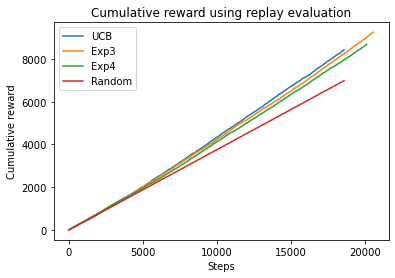

In [ ]:
random = np.full(len(ucb),data['Liked'].value_counts(normalize=True)[1])

fig1, ax1 = plt.subplots()
ax1.plot(range(len(ucb)), np.cumsum(ucb), label='UCB')
ax1.plot(range(len(exp3)), np.cumsum(exp3), label='Exp3')
ax1.plot(range(len(exp4)), np.cumsum(exp4), label='Exp4')
ax1.plot(range(len(random)), np.cumsum(random), label='Random')
ax1.set_title("Cumulative reward using replay evaluation")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Cumulative reward")
plt.legend()

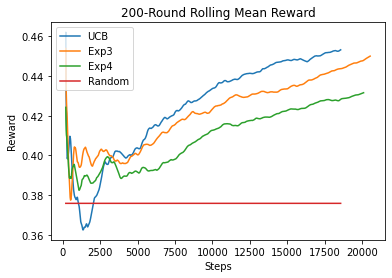

In [ ]:
cumulative_random = np.cumsum(random) / np.linspace(1, len(random), len(random))
cumulative_ucb = np.cumsum(ucb) / np.linspace(1, len(ucb), len(ucb))
cumulative_exp3 = np.cumsum(exp3) / np.linspace(1, len(exp3), len(exp3))
cumulative_exp4 = np.cumsum(exp4) / np.linspace(1, len(exp4), len(exp4))

fig1, ax1 = plt.subplots()
ax1.plot(range(len(ucb)), np.asarray(pd.Series(cumulative_ucb).rolling(200).mean()), label='UCB')
ax1.plot(range(len(exp3)), np.asarray(pd.Series(cumulative_exp3).rolling(200).mean()), label='Exp3')
ax1.plot(range(len(exp4)), np.asarray(pd.Series(cumulative_exp4).rolling(200).mean()), label='Exp4')
ax1.plot(range(len(random)), np.asarray(pd.Series(cumulative_random).rolling(200).mean()), label='Random')
ax1.set_title("200-Round Rolling Mean Reward")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Reward")
plt.legend()